# Running Inference
This notebook will contain demonstrations on how to run inference using the SRGAN network. 

In [39]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from trainer.libs.srgan import SRGAN
from trainer.libs.util import DataLoader

# 1. Load model & Weights

In [2]:
# Instantiate the model
gan = SRGAN(upscaling_factor=4, training_mode=False, generator_weights='trainer/data/weights/epoch11.h5')

# Load weights - this assumes you've already trained the network!
# Replace filename with the location of your trained weights

Instructions for updating:
Colocations handled automatically by placer.
Done with weights
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, None, None, 6 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       p_re_lu_1[0][0]                  
___________________

## 2.2. Inference on images from internet

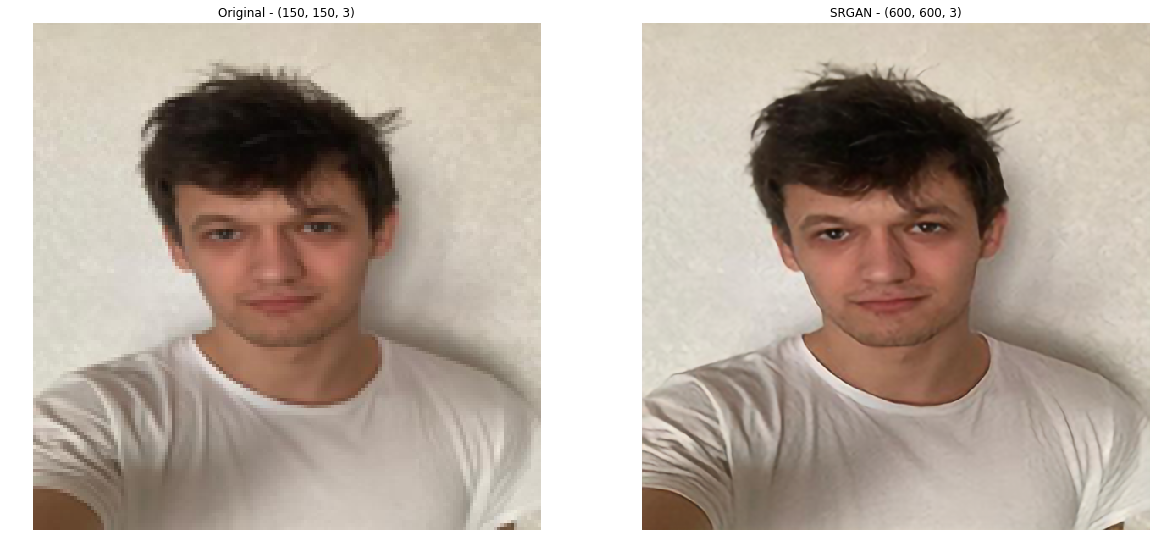

In [63]:
# Load image
img_lr = DataLoader.load_img("trainer/data/test/roma.jpg").astype(np.uint8)

# Resize image (you can skip this if you are doing it on original image)
img_lr = np.array(Image.fromarray(img_lr).resize((150, 150), Image.BICUBIC))

# Scale image
img_lr = DataLoader.scale_lr_imgs(img_lr)

# # Predict high-resolution version (add batch dimension to image)
img_sr = np.squeeze(
    gan.generator.predict(
        np.expand_dims(img_lr, 0), 
        batch_size=1
    ), 
    axis=0
)

# Unscale colors
img_sr = DataLoader.unscale_hr_imgs(img_sr).astype(np.uint8)
img_lr = DataLoader.unscale_lr_imgs(img_lr).astype(np.uint8)

# Images and titles
images = {
    'Original': img_lr, 
    'SRGAN': img_sr, 
}

# Plot the images. Note: rescaling and using squeeze since we are getting batches of size 1                    
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, (title, img) in enumerate(images.items()):    
    axes[i].imshow(img)
    axes[i].set_title("{} - {}".format(title, img.shape))
    axes[i].axis('off')
plt.show()

# Online Prediction

In [34]:
from PIL import Image
import numpy as np
#Resize the original image.

img_lr = DataLoader.load_img('export/fraud.png').astype(np.uint8)
img_lr = np.array(Image.fromarray(img_lr).resize((300, int(300)), Image.BICUBIC))

print(np.array(img_lr).shape)
img_lr = DataLoader.scale_lr_imgs(img_lr)
input_dict={'image': img_lr.tolist()}

import json
with open('export/test_data.json', 'w') as outfile:
    json.dump(input_dict, outfile)

(150, 150, 3)


In [35]:
from googleapiclient.discovery import build

def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    service = build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [53]:
img_lr.shape

(150, 150, 3)

In [54]:
out = predict_json(project='revolut-edw', model='DNN_Retail', instances=[img_lr.tolist()])

/anaconda3/envs/ml36/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [55]:
img_sr = np.array(out[0]['scores'])
img_sr.sum()

1079993.992085874

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


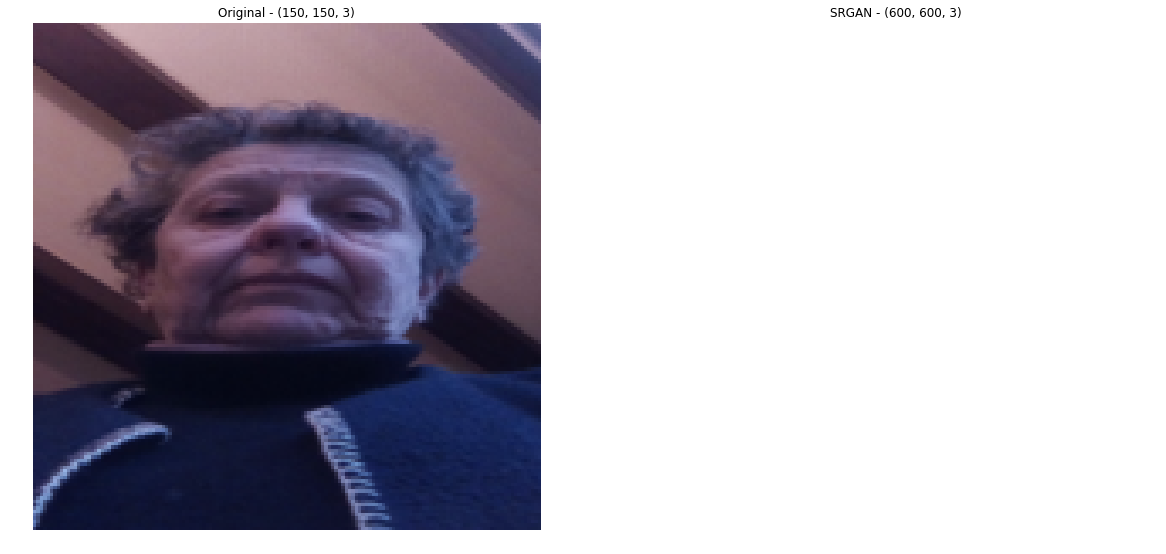

In [42]:
img_sr = np.array(out[0]['scores'])
img_sr = DataLoader.unscale_hr_imgs(img_sr)

images = {
    'Original': np.array(img_lr), 
    'SRGAN': img_sr, 
}

import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, (title, img) in enumerate(images.items()):    
    axes[i].imshow(img)
    axes[i].set_title("{} - {}".format(title, img.shape))
    axes[i].axis('off')
plt.show()